In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")

    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/ResNet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_imageNet/resnet50_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_imageNet/resnet50_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")



FOLD 1/5
--------------------
Epoch 1: Loss 0.0908
Epoch 2: Loss 0.0597
Epoch 3: Loss 0.0361
Epoch 4: Loss 0.0130
Epoch 5: Loss 0.0084
Fold 1 Accuracy: 1.0000

FOLD 2/5
--------------------
Epoch 1: Loss 0.1081
Epoch 2: Loss 0.0313
Epoch 3: Loss 0.0280
Epoch 4: Loss 0.0137
Epoch 5: Loss 0.0156
Fold 2 Accuracy: 1.0000

FOLD 3/5
--------------------
Epoch 1: Loss 0.0972
Epoch 2: Loss 0.0194
Epoch 3: Loss 0.0115
Epoch 4: Loss 0.0246
Epoch 5: Loss 0.0078
Fold 3 Accuracy: 1.0000

FOLD 4/5
--------------------
Epoch 1: Loss 0.1016
Epoch 2: Loss 0.0377
Epoch 3: Loss 0.0156
Epoch 4: Loss 0.0068
Epoch 5: Loss 0.0011
Fold 4 Accuracy: 1.0000

FOLD 5/5
--------------------
Epoch 1: Loss 0.0830
Epoch 2: Loss 0.0382
Epoch 3: Loss 0.0169
Epoch 4: Loss 0.0179
Epoch 5: Loss 0.0036
Fold 5 Accuracy: 1.0000

Mean Accuracy across 5 folds: 1.0000
Best Accuracy observed: 1.0000
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_imageNet/resnet50_img_best.pth


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")

    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/resnet50_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/resnet50_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")



FOLD 1/5
--------------------
Epoch 1: Loss 0.3489
Epoch 2: Loss 0.1987
Epoch 3: Loss 0.1486
Epoch 4: Loss 0.1018
Epoch 5: Loss 0.0709
Fold 1 Accuracy: 0.8654

FOLD 2/5
--------------------
Epoch 1: Loss 0.3487
Epoch 2: Loss 0.1618
Epoch 3: Loss 0.0896
Epoch 4: Loss 0.0800
Epoch 5: Loss 0.0437
Fold 2 Accuracy: 0.9423

FOLD 3/5
--------------------
Epoch 1: Loss 0.3434
Epoch 2: Loss 0.1440
Epoch 3: Loss 0.0786
Epoch 4: Loss 0.0904
Epoch 5: Loss 0.0609
Fold 3 Accuracy: 0.9753

FOLD 4/5
--------------------
Epoch 1: Loss 0.3441
Epoch 2: Loss 0.1525
Epoch 3: Loss 0.1041
Epoch 4: Loss 0.0658
Epoch 5: Loss 0.0522
Fold 4 Accuracy: 0.9807

FOLD 5/5
--------------------
Epoch 1: Loss 0.3295
Epoch 2: Loss 0.1774
Epoch 3: Loss 0.0897
Epoch 4: Loss 0.1019
Epoch 5: Loss 0.0684
Fold 5 Accuracy: 0.9725

Mean Accuracy across 5 folds: 0.9472
Best Accuracy observed: 0.9807
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/resnet50_syn_best.pth

Lib+Keells

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")

    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/ResNet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_imagenet/resnet50_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_imagenet/resnet50_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")



FOLD 1/5
--------------------
Epoch 1: Loss 0.1025
Epoch 2: Loss 0.0464
Epoch 3: Loss 0.0377
Epoch 4: Loss 0.0090
Epoch 5: Loss 0.0042
Fold 1 Accuracy: 0.9941

FOLD 2/5
--------------------
Epoch 1: Loss 0.1180
Epoch 2: Loss 0.0349
Epoch 3: Loss 0.0339
Epoch 4: Loss 0.0239
Epoch 5: Loss 0.0291
Fold 2 Accuracy: 0.9941

FOLD 3/5
--------------------
Epoch 1: Loss 0.1207
Epoch 2: Loss 0.0354
Epoch 3: Loss 0.0166
Epoch 4: Loss 0.0238
Epoch 5: Loss 0.0058
Fold 3 Accuracy: 0.9961

FOLD 4/5
--------------------
Epoch 1: Loss 0.1247
Epoch 2: Loss 0.0339
Epoch 3: Loss 0.0286
Epoch 4: Loss 0.0137
Epoch 5: Loss 0.0223
Fold 4 Accuracy: 0.9961

FOLD 5/5
--------------------
Epoch 1: Loss 0.1171
Epoch 2: Loss 0.0383
Epoch 3: Loss 0.0132
Epoch 4: Loss 0.0157
Epoch 5: Loss 0.0282
Fold 5 Accuracy: 0.9922

Mean Accuracy across 5 folds: 0.9945
Best Accuracy observed: 0.9961
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_imagenet/resnet50_im

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")

    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_synthetic/resnet50_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_synthetic/resnet50_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")



FOLD 1/5
--------------------
Epoch 1: Loss 0.3984
Epoch 2: Loss 0.1952
Epoch 3: Loss 0.1365
Epoch 4: Loss 0.1052
Epoch 5: Loss 0.0889
Fold 1 Accuracy: 0.9393

FOLD 2/5
--------------------
Epoch 1: Loss 0.3404
Epoch 2: Loss 0.1762
Epoch 3: Loss 0.1415
Epoch 4: Loss 0.1112
Epoch 5: Loss 0.0709
Fold 2 Accuracy: 0.9550

FOLD 3/5
--------------------
Epoch 1: Loss 0.3273
Epoch 2: Loss 0.1977
Epoch 3: Loss 0.1110
Epoch 4: Loss 0.1137
Epoch 5: Loss 0.0714
Fold 3 Accuracy: 0.9608

FOLD 4/5
--------------------
Epoch 1: Loss 0.3647
Epoch 2: Loss 0.2046
Epoch 3: Loss 0.1360
Epoch 4: Loss 0.0990
Epoch 5: Loss 0.0773
Fold 4 Accuracy: 0.9667

FOLD 5/5
--------------------
Epoch 1: Loss 0.3544
Epoch 2: Loss 0.1611
Epoch 3: Loss 0.1189
Epoch 4: Loss 0.0879
Epoch 5: Loss 0.1028
Fold 5 Accuracy: 0.9353

Mean Accuracy across 5 folds: 0.9514
Best Accuracy observed: 0.9667
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_imagenet/resnet50_sy

##########LIB_KEELLS_AUG##########

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")

    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/ResNet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_imagenet/resnet50_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_imagenet/resnet50_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")



FOLD 1/5
--------------------
Epoch 1: Loss 0.1029
Epoch 2: Loss 0.0488
Epoch 3: Loss 0.0167
Epoch 4: Loss 0.0113
Epoch 5: Loss 0.0073
Fold 1 Accuracy: 0.9967

FOLD 2/5
--------------------
Epoch 1: Loss 0.1192
Epoch 2: Loss 0.0273
Epoch 3: Loss 0.0290
Epoch 4: Loss 0.0170
Epoch 5: Loss 0.0156
Fold 2 Accuracy: 0.9967

FOLD 3/5
--------------------
Epoch 1: Loss 0.1138
Epoch 2: Loss 0.0516
Epoch 3: Loss 0.0222
Epoch 4: Loss 0.0123
Epoch 5: Loss 0.0093
Fold 3 Accuracy: 0.9933

FOLD 4/5
--------------------
Epoch 1: Loss 0.1200
Epoch 2: Loss 0.0356
Epoch 3: Loss 0.0224
Epoch 4: Loss 0.0206
Epoch 5: Loss 0.0263
Fold 4 Accuracy: 0.9900

FOLD 5/5
--------------------
Epoch 1: Loss 0.1017
Epoch 2: Loss 0.0421
Epoch 3: Loss 0.0118
Epoch 4: Loss 0.0361
Epoch 5: Loss 0.0083
Fold 5 Accuracy: 1.0000

Mean Accuracy across 5 folds: 0.9953
Best Accuracy observed: 1.0000
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_imagenet/resnet5

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")

    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_synthetic/resnet50_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_synthetic/resnet50_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")



FOLD 1/5
--------------------
Epoch 1: Loss 0.3652
Epoch 2: Loss 0.1886
Epoch 3: Loss 0.1054
Epoch 4: Loss 0.0908
Epoch 5: Loss 0.0909
Fold 1 Accuracy: 0.9433

FOLD 2/5
--------------------
Epoch 1: Loss 0.3930
Epoch 2: Loss 0.1479
Epoch 3: Loss 0.1094
Epoch 4: Loss 0.1031
Epoch 5: Loss 0.0663
Fold 2 Accuracy: 0.9300

FOLD 3/5
--------------------
Epoch 1: Loss 0.3664
Epoch 2: Loss 0.1854
Epoch 3: Loss 0.1098
Epoch 4: Loss 0.0687
Epoch 5: Loss 0.1007
Fold 3 Accuracy: 0.8564

FOLD 4/5
--------------------
Epoch 1: Loss 0.3549
Epoch 2: Loss 0.1754
Epoch 3: Loss 0.1110
Epoch 4: Loss 0.0914
Epoch 5: Loss 0.0700
Fold 4 Accuracy: 0.9583

FOLD 5/5
--------------------
Epoch 1: Loss 0.3305
Epoch 2: Loss 0.1648
Epoch 3: Loss 0.1186
Epoch 4: Loss 0.0959
Epoch 5: Loss 0.0676
Fold 5 Accuracy: 0.9316

Mean Accuracy across 5 folds: 0.9239
Best Accuracy observed: 0.9583
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_imagenet/resnet5

###TRAIN with early stopping##


FOLD 1/5
--------------------
Epoch 1: Train Loss 0.3489, Train Acc 0.6629, Val Loss 0.1503, Val Acc 0.8733
Epoch 2: Train Loss 0.1713, Train Acc 0.8456, Val Loss 0.1409, Val Acc 0.8750
Epoch 3: Train Loss 0.1043, Train Acc 0.8924, Val Loss 0.0376, Val Acc 0.9683
Epoch 4: Train Loss 0.0978, Train Acc 0.9120, Val Loss 0.0537, Val Acc 0.9583
Epoch 5: Train Loss 0.0704, Train Acc 0.9366, Val Loss 0.1081, Val Acc 0.9233
Epoch 6: Train Loss 0.0547, Train Acc 0.9520, Val Loss 0.0287, Val Acc 0.9767
Epoch 7: Train Loss 0.0482, Train Acc 0.9574, Val Loss 0.0399, Val Acc 0.9667
Epoch 8: Train Loss 0.0349, Train Acc 0.9654, Val Loss 0.0819, Val Acc 0.9283
Epoch 9: Train Loss 0.0569, Train Acc 0.9533, Val Loss 0.0373, Val Acc 0.9717
Early stopping at epoch 9
Fold 1 Best Val Accuracy: 0.9767

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.3803, Train Acc 0.6354, Val Loss 0.3035, Val Acc 0.6867
Epoch 2: Train Loss 0.1652, Train Acc 0.8515, Val Loss 0.1139, Val Acc 0.9183
Epoch 3: Train Loss 0

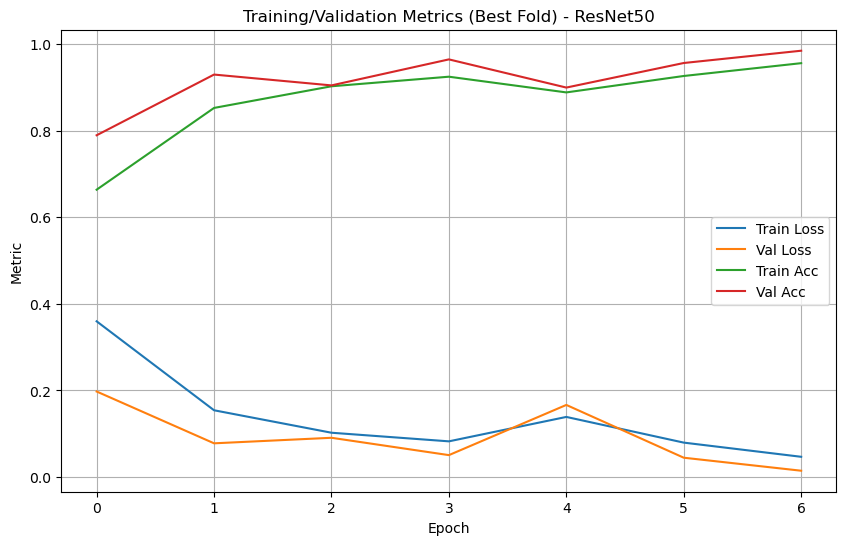

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")
    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None

# Early stopping
patience = 3
min_delta = 1e-4

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="synthetic")   # or "imagenet"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # ---- Validation ----
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ---- Early stopping ----
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_synthetic/resnet50_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_synthetic/resnet50_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)

# -------------------- Plot Best Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold) - ResNet50")
plt.legend()
plt.grid(True)
plt.show()



FOLD 1/5
--------------------
Epoch 1: Train Loss 0.0975, Train Acc 0.9124, Val Loss 0.0434, Val Acc 0.9617
Epoch 2: Train Loss 0.0330, Train Acc 0.9746, Val Loss 0.0036, Val Acc 0.9983
Epoch 3: Train Loss 0.0196, Train Acc 0.9816, Val Loss 0.0066, Val Acc 0.9950
Epoch 4: Train Loss 0.0165, Train Acc 0.9841, Val Loss 0.0027, Val Acc 0.9983
Epoch 5: Train Loss 0.0256, Train Acc 0.9808, Val Loss 0.0066, Val Acc 0.9967
Early stopping at epoch 5
Fold 1 Best Val Accuracy: 0.9983

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.1095, Train Acc 0.9074, Val Loss 0.0214, Val Acc 0.9867
Epoch 2: Train Loss 0.0458, Train Acc 0.9616, Val Loss 0.0148, Val Acc 0.9900
Epoch 3: Train Loss 0.0178, Train Acc 0.9804, Val Loss 0.0013, Val Acc 0.9983
Epoch 4: Train Loss 0.0121, Train Acc 0.9896, Val Loss 0.0005, Val Acc 1.0000
Epoch 5: Train Loss 0.0050, Train Acc 0.9967, Val Loss 0.0007, Val Acc 1.0000
Epoch 6: Train Loss 0.0028, Train Acc 0.9983, Val Loss 0.0015, Val Acc 0.9983
Epoch 7: Train Loss 0

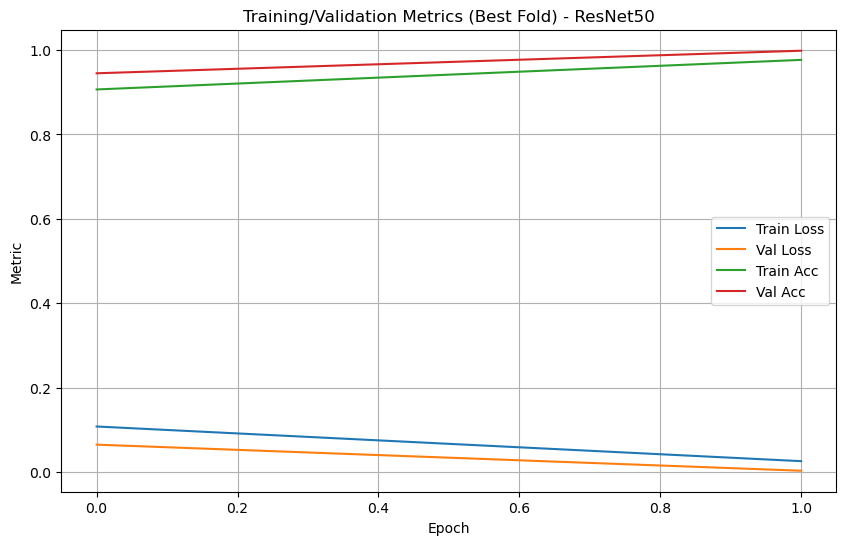

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")
    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None

# Early stopping
patience = 3
min_delta = 1e-4

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="imagenet")   # or "imagenet"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # ---- Validation ----
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ---- Early stopping ----
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_imagenet/resnet50_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_imagenet/resnet50_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)

# -------------------- Plot Best Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold) - ResNet50")
plt.legend()
plt.grid(True)
plt.show()



FOLD 1/5
--------------------
Epoch 1: Train Loss 0.3122, Train Acc 0.7000, Val Loss 0.5406, Val Acc 0.5191
Epoch 2: Train Loss 0.1537, Train Acc 0.8505, Val Loss 0.2238, Val Acc 0.8295
Epoch 3: Train Loss 0.1226, Train Acc 0.8896, Val Loss 0.0374, Val Acc 0.9618
Epoch 4: Train Loss 0.0701, Train Acc 0.9278, Val Loss 0.0342, Val Acc 0.9618
Epoch 5: Train Loss 0.0626, Train Acc 0.9494, Val Loss 0.0173, Val Acc 0.9835
Epoch 6: Train Loss 0.0440, Train Acc 0.9631, Val Loss 0.0174, Val Acc 0.9860
Epoch 7: Train Loss 0.0452, Train Acc 0.9577, Val Loss 0.0097, Val Acc 0.9949
Epoch 8: Train Loss 0.0296, Train Acc 0.9720, Val Loss 0.0093, Val Acc 0.9924
Epoch 9: Train Loss 0.0370, Train Acc 0.9612, Val Loss 0.0117, Val Acc 0.9873
Epoch 10: Train Loss 0.0391, Train Acc 0.9586, Val Loss 0.0313, Val Acc 0.9809
Early stopping at epoch 10
Fold 1 Best Val Accuracy: 0.9949

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.3048, Train Acc 0.6974, Val Loss 0.1780, Val Acc 0.8397
Epoch 2: Train Loss

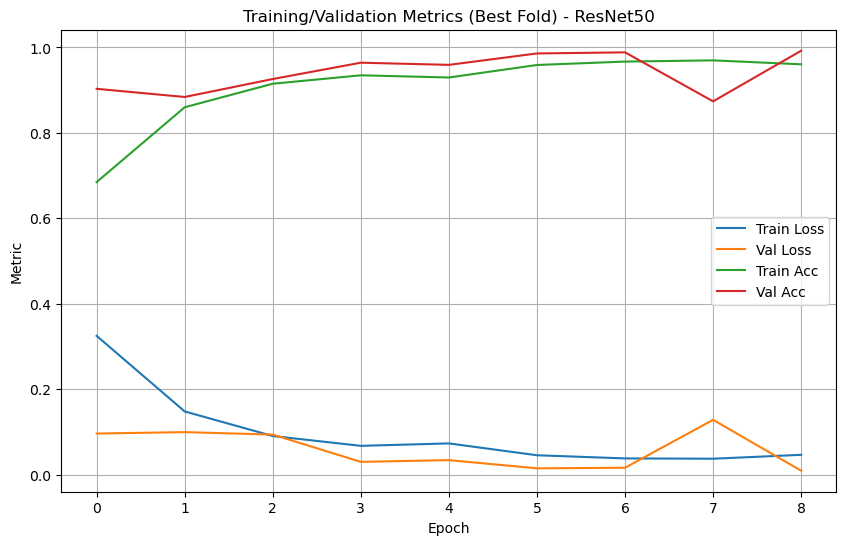

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_keells_Aug_left_right/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")
    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None

# Early stopping
patience = 3
min_delta = 1e-4

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="synthetic")   # or "imagenet"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # ---- Validation ----
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ---- Early stopping ----
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history) #this parameter updates every fold
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/syn/resnet50_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/syn/resnet50_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)

# -------------------- Plot last fold's grpah History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss") 
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold) - ResNet50")
plt.legend()
plt.grid(True)
plt.show()



FOLD 1/5
--------------------
Epoch 1: Train Loss 0.0898, Train Acc 0.9173, Val Loss 0.0081, Val Acc 0.9962
Epoch 2: Train Loss 0.0397, Train Acc 0.9666, Val Loss 0.0090, Val Acc 0.9949
Epoch 3: Train Loss 0.0104, Train Acc 0.9911, Val Loss 0.0002, Val Acc 1.0000
Epoch 4: Train Loss 0.0137, Train Acc 0.9889, Val Loss 0.0172, Val Acc 0.9873
Epoch 5: Train Loss 0.0164, Train Acc 0.9873, Val Loss 0.0238, Val Acc 0.9656
Epoch 6: Train Loss 0.0072, Train Acc 0.9943, Val Loss 0.0004, Val Acc 1.0000
Early stopping at epoch 6
Fold 1 Best Val Accuracy: 1.0000

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.0824, Train Acc 0.9287, Val Loss 0.0006, Val Acc 1.0000
Epoch 2: Train Loss 0.0391, Train Acc 0.9675, Val Loss 0.0008, Val Acc 1.0000
Epoch 3: Train Loss 0.0210, Train Acc 0.9825, Val Loss 0.0015, Val Acc 0.9987
Epoch 4: Train Loss 0.0084, Train Acc 0.9936, Val Loss 0.0008, Val Acc 1.0000
Early stopping at epoch 4
Fold 2 Best Val Accuracy: 1.0000

FOLD 3/5
--------------------
Epoch 1: 

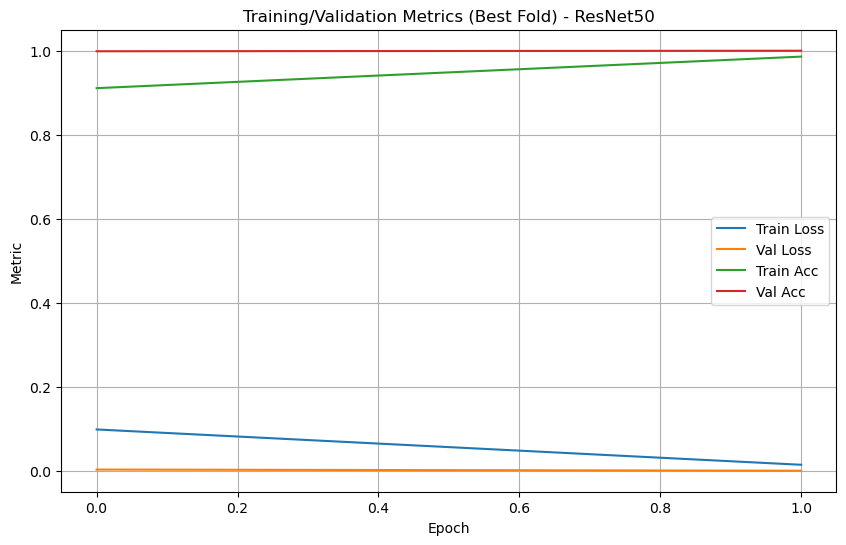

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_keells_Aug_left_right/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")
    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None

# Early stopping
patience = 3
min_delta = 1e-4

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="imagenet")   # or "imagenet"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # ---- Validation ----
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ---- Early stopping ----
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/img/resnet50_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/img/resnet50_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)

# -------------------- Plot final Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold) - ResNet50")
plt.legend()
plt.grid(True)
plt.show()


session 2 img weights


FOLD 1/5
--------------------
Epoch 1: Train Loss 0.0852, Train Acc 0.9217, Val Loss 0.0023, Val Acc 0.9987
Epoch 2: Train Loss 0.0385, Train Acc 0.9666, Val Loss 0.0018, Val Acc 1.0000
Epoch 3: Train Loss 0.0138, Train Acc 0.9885, Val Loss 0.0002, Val Acc 1.0000
Epoch 4: Train Loss 0.0135, Train Acc 0.9895, Val Loss 0.0003, Val Acc 1.0000
Epoch 5: Train Loss 0.0185, Train Acc 0.9854, Val Loss 0.0017, Val Acc 0.9987
Early stopping at epoch 5
Fold 1 Best Val Accuracy: 1.0000
 Saved best model for Fold 1 at: /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/session2/img/rn/fold_1/resnet50_fold1_best.pth

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.0862, Train Acc 0.9157, Val Loss 0.2888, Val Acc 0.9109
Epoch 2: Train Loss 0.0325, Train Acc 0.9745, Val Loss 0.0023, Val Acc 0.9987
Epoch 3: Train Loss 0.0267, Train Acc 0.9752, Val Loss 0.0012, Val Acc 1.0000
Epoch 4: Train Loss 0.0148, Train Acc 0.9854, Val Loss 0.0012, Val Acc 1.0000
E

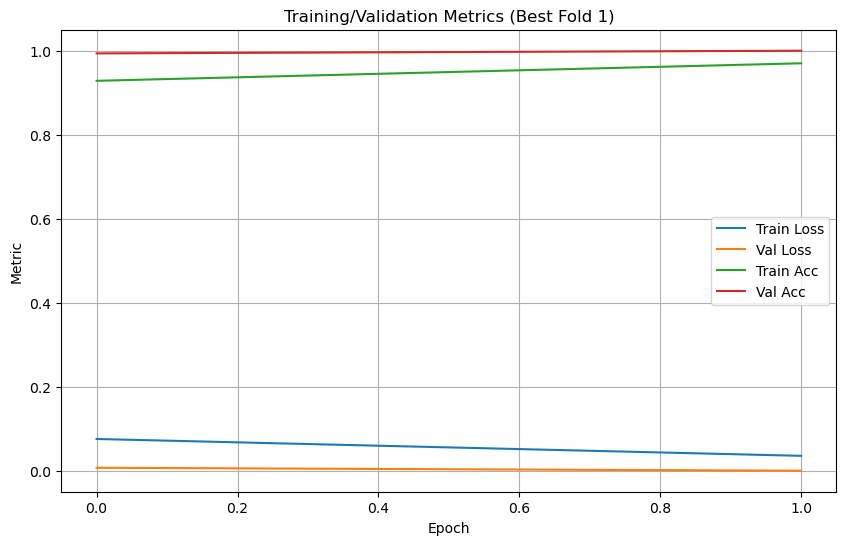

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("RGB")  # convert to 3-channel RGB
        if self.transform:
            img = self.transform(img)

        return img, label


# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_keells_Aug_left_right/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")
    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model


# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None
best_fold_idx = None  # <<< --- track best fold index --- >>>

# Early stopping config
patience = 3
min_delta = 1e-4

save_root = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/session2/img/rn/"  # <<< --- base path --- >>>
os.makedirs(save_root, exist_ok=True)

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold + 1}/{k_folds}")
    print("-" * 20)

    train_sub = Subset(dataset, train_ids)
    val_sub = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="imagenet")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # Validation
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch + 1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Early stopping
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold + 1} Best Val Accuracy: {best_val_acc:.4f}")

    # <<< --- save each fold model --- >>>
    fold_dir = os.path.join(save_root, f"fold_{fold + 1}")
    os.makedirs(fold_dir, exist_ok=True)
    fold_model_path = os.path.join(fold_dir, f"resnet50_fold{fold + 1}_best.pth")
    torch.save(best_fold_wts, fold_model_path)
    print(f" Saved best model for Fold {fold + 1} at: {fold_model_path}")

    # track best overall fold
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)
        best_fold_history = deepcopy(history)
        best_fold_idx = fold + 1

# -------------------- Summary --------------------
print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f} (Fold {best_fold_idx})")

# <<< --- Save best overall model --- >>>
best_model_path = os.path.join(save_root, f"resnet50_best_overall_fold{best_fold_idx}.pth")
torch.save(best_model_wts, best_model_path)
print(f" Best overall model saved to: {best_model_path}")

# -------------------- Plot Best Fold History --------------------
plt.figure(figsize=(10, 6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title(f"Training/Validation Metrics (Best Fold {best_fold_idx})")
plt.legend()
plt.grid(True)
plt.show()


session2 syn


FOLD 1/5
--------------------
Epoch 1: Train Loss 0.3302, Train Acc 0.6640, Val Loss 0.1618, Val Acc 0.8193
Epoch 2: Train Loss 0.1395, Train Acc 0.8686, Val Loss 0.1196, Val Acc 0.8855
Epoch 3: Train Loss 0.0981, Train Acc 0.9103, Val Loss 0.0208, Val Acc 0.9771
Epoch 4: Train Loss 0.0781, Train Acc 0.9290, Val Loss 0.0492, Val Acc 0.9580
Epoch 5: Train Loss 0.0553, Train Acc 0.9520, Val Loss 0.0223, Val Acc 0.9746
Epoch 6: Train Loss 0.0451, Train Acc 0.9596, Val Loss 0.0179, Val Acc 0.9847
Epoch 7: Train Loss 0.0329, Train Acc 0.9698, Val Loss 0.0081, Val Acc 0.9924
Epoch 8: Train Loss 0.0595, Train Acc 0.9437, Val Loss 0.0354, Val Acc 0.9631
Epoch 9: Train Loss 0.0386, Train Acc 0.9666, Val Loss 0.0373, Val Acc 0.9707
Epoch 10: Train Loss 0.0333, Train Acc 0.9739, Val Loss 0.0027, Val Acc 0.9987
Epoch 11: Train Loss 0.0209, Train Acc 0.9790, Val Loss 0.0023, Val Acc 0.9987
Epoch 12: Train Loss 0.0246, Train Acc 0.9765, Val Loss 0.0039, Val Acc 0.9962
Epoch 13: Train Loss 0.0180, T

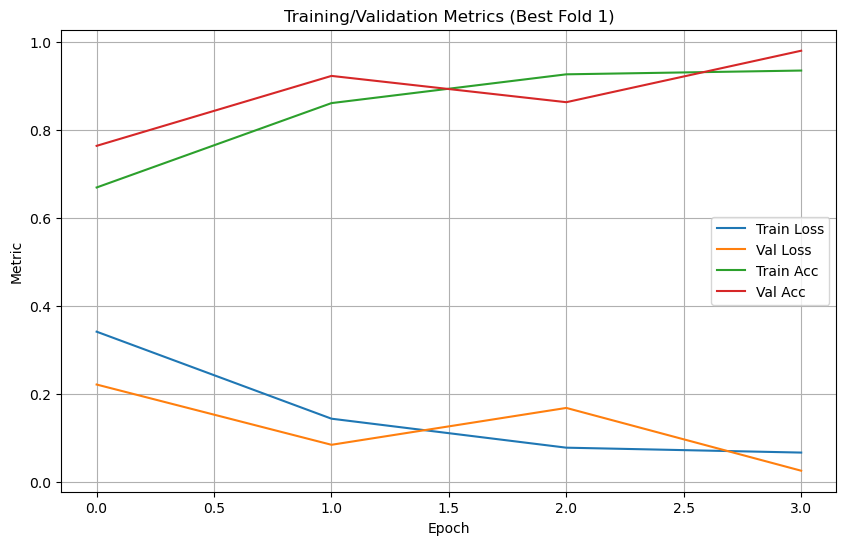

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)

        return img, label


# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_keells_Aug_left_right/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.resnet50(weights="IMAGENET1K_V1")
    elif pretrained == "synthetic":
        # create same architecture
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/Resnet50/resnet50_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block (layer4 in ResNet)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace fc layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    return model


# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None
best_fold_idx = None  # <<< --- track best fold index --- >>>

# Early stopping config
patience = 3
min_delta = 1e-4

save_root = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/session2/syn/rn/"  # <<< --- base path --- >>>
os.makedirs(save_root, exist_ok=True)

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold + 1}/{k_folds}")
    print("-" * 20)

    train_sub = Subset(dataset, train_ids)
    val_sub = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="synthetic")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # Validation
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch + 1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Early stopping
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold + 1} Best Val Accuracy: {best_val_acc:.4f}")

    # <<< --- save each fold model --- >>>
    fold_dir = os.path.join(save_root, f"fold_{fold + 1}")
    os.makedirs(fold_dir, exist_ok=True)
    fold_model_path = os.path.join(fold_dir, f"resnet50_fold{fold + 1}_best.pth")
    torch.save(best_fold_wts, fold_model_path)
    print(f" Saved best model for Fold {fold + 1} at: {fold_model_path}")

    # track best overall fold
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)
        best_fold_history = deepcopy(history)
        best_fold_idx = fold + 1

# -------------------- Summary --------------------
print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f} (Fold {best_fold_idx})")

# <<< --- Save best overall model --- >>>
best_model_path = os.path.join(save_root, f"resnet50_best_overall_fold{best_fold_idx}.pth")
torch.save(best_model_wts, best_model_path)
print(f" Best overall model saved to: {best_model_path}")

# -------------------- Plot Best Fold History --------------------
plt.figure(figsize=(10, 6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title(f"Training/Validation Metrics (Best Fold {best_fold_idx})")
plt.legend()
plt.grid(True)
plt.show()
